## Import libraries

In [1]:
# Import Libraries 
library(tidyverse)
library(janitor)
library(stringr)
library(lubridate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




## Import data and create dataframes

In [2]:
# Documenting Steps for Downloading Data Files

# Salary file
#python download_data.py --url=https://github.com/invinst/chicago-police-data/blob/master/data/unified_data/salary/salary-ranks_2002-2017_2017-09.csv.gz?raw=true --path=../data/salary.csv

# Accused file
#python download_data.py --url=https://github.com/invinst/chicago-police-data/blob/master/data/unified_data/complaints/complaints-accused.csv.gz?raw=true --path=../data/accused.csv

# Complaints file
#python download_data.py --url=https://github.com/invinst/chicago-police-data/blob/master/data/unified_data/complaints/complaints-complaints.csv.gz?raw=true --path=../data/complaints.csv

# Demographics file 
#python download_data.py --url=https://github.com/invinst/chicago-police-data/blob/master/data/unified_data/profiles/final-profiles.csv.gz?raw=true --path=../data/demographics.csv

In [3]:
# Load csv files.  Readin all columns as characters, eliminates issues with formatting (some cr_id were defaulting to NA)
accused_df <- read_csv("../data/accused.csv", col_type = paste(rep("c",10),collapse = ""))
complaints_df <- read_csv("../data/complaints.csv", col_type = paste(rep("c",11),collapse = ""))
salary_df <- read_csv("../data/salary.csv", col_types = paste(rep("c",8),collapse = ""))
demographics_df <- read_csv("../data/demographics.csv", col_types = paste(rep("c",20), collapse = ""))

complaints_all_staff <- read_csv("../data/complaints_all_staff.csv")
complaints_police <- read_csv("../data/complaints_police.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  salary = col_double(),
  year = col_double(),
  cleaned_rank = col_character(),
  link_UID = col_double(),
  complaints_per_year = col_double(),
  race = col_character(),
  gender = col_character(),
  birth_year = col_double(),
  org_hire_date = col_date(format = ""),
  start_date = col_date(format = ""),
  resignation_date = col_date(format = ""),
  approx_age = col_double(),
  approx_years_service = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  salary = col_double(),
  year = col_double(),
  cleaned_rank = col_character(),
  link_UID = col_double(),
  complaints_per_year = col_double(),
  race = col_character(),
  gender = col_character(),
  birth_year = col_double(),
  org_hire_date = col_date(format = ""),
  start_date = col_date(format = ""),
  resignation_date = col_date(format = ""),
  approx_age = col_double(),
  approx_years_ser

In [4]:
# See first few rows of DFs
head(accused_df)
head(complaints_df)
head(salary_df)
head(demographics_df)

head(complaints_all_staff)
head(complaints_police)

UID,complaint_category,complaint_code,cr_id,cv,final_finding,final_outcome,recc_finding,recc_outcome,link_UID
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
130469.0,SUPERVISOR RESPONSIBILITY: FAIL TO OBTAIN COMPLAINT REGISTER NO.,12D,C170981,1,NS,NO ACTION TAKEN,NA,NA,20040.0
103495.0,EXCESSIVE FORCE: ARRESTEE - DURING ARREST,05A,C170981,1,NS,NO ACTION TAKEN,NA,NA,7727.0
111845.0,EXCESSIVE FORCE: ARRESTEE - DURING ARREST,05A,C170981,1,NS,NO ACTION TAKEN,NA,NA,17149.0
126148.0,EXCESSIVE FORCE: ARRESTEE - DURING ARREST,05A,C170981,1,NS,NO ACTION TAKEN,NA,NA,271.0
127906.0,EXCESSIVE FORCE: ARRESTEE - DURING ARREST,05A,C170981,1,NS,NO ACTION TAKEN,NA,NA,11004.0
117100.0,EXCESSIVE FORCE: NO ARREST,05D,C171131,1,EX,NO ACTION TAKEN,NA,NA,25023.0


cr_id,cv,incident_date,complaint_date,closed_date,add1,add2,beat,city,full_address,location
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1000194,2,2006-10-02,2006-10-02,NA,7809,S SOUTH SHORE DR,421.0,CHICAGO IL,NA,17
1000214,3,2006-10-03,2006-10-04,2010-12-23,7100,South WESTERN AVE,832.0,CHICAGO ILLINOIS 60636,NA,NA
1002796,3,2006-12-15,2007-01-18,2008-12-15,325,North JEFFERSON ST,1212.0,CHICAGO ILLINOIS 60661,NA,TAVERN/LIQUOR STORE
1003786,3,2007-03-01,2007-03-02,2011-02-23,NA,West 87TH ST,834.0,CHICAGO ILLINOIS 60652,NA,RESIDENCE
1005070,2,2007-04-20,2007-04-20,NA,4010,W ERIE ST,0.0,CHICAGO IL,NA,17
1005436,2,2005-05-15,2007-05-04,NA,4427,S KARLOV AVE,815.0,CHICAGO IL 60632,NA,17


UID,pay_grade,rank,salary,year,spp_date,cleaned_rank,link_UID
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
100011.0,E|3,SERGEANT,101442.0,2016.0,2016-02-01,SERGEANT,3978.0
100013.0,E|3,SERGEANT,111474.0,2016.0,2016-06-01,SERGEANT,4443.0
100014.0,D|2A,POLICE OFFICER (ASSIGNED AS DETECTIVE),76446.0,2007.0,2007-04-01,DETECTIVE,4879.0
100027.0,E|3,SERGEANT,98184.0,2016.0,2016-06-01,SERGEANT,16115.0
100044.0,D|2,POLICE OFFICER (ASSIGNED AS EVIDENCE TECHNICIAN),61518.0,2004.0,2004-12-01,POLICE OFFICER,38.0
100054.0,D|2,POLICE OFFICER/EXPLSV DETECT K9 HNDLR,87048.0,2011.0,2011-06-16,POLICE OFFICER,9432.0


UID,first_name,last_name,middle_initial,middle_initial2,suffix_name,birth_year,race,gender,appointed_date,resignation_date,current_status,current_star,current_unit,current_rank,start_date,org_hire_date,profile_count,cleaned_rank,link_UID
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
100001,A,BRODERSON,F,NA,NA,1926.0,WHITE,MALE,1950-06-03,1980-03-10,0.0,NA,NA,NA,NA,NA,3,NA,2863.0
100002,A,DALESSANDRO,A,NA,NA,1923.0,WHITE,MALE,1956-09-01,1979-10-18,0.0,NA,NA,NA,NA,NA,3,NA,6100.0
100003,A,KIBURAS,J,NA,NA,1948.0,WHITE,MALE,1968-06-24,1980-10-01,0.0,NA,NA,NA,NA,NA,3,NA,14560.0
100004,A,KUSTRA,J,NA,NA,1923.0,WHITE,MALE,1953-09-28,1980-10-01,0.0,NA,NA,NA,NA,NA,3,NA,15445.0
100005,A,MC LAUGHLIN,R,NA,NA,1941.0,BLACK,MALE,1966-06-20,1986-09-16,0.0,NA,123.0,POLICE OFFICER,NA,NA,3,POLICE OFFICER,18373.0
100006,A RICHARD,LABRIOLA,NA,NA,NA,1943.0,WHITE,MALE,1971-10-25,2004-03-15,0.0,NA,8.0,POLICE OFFICER,NA,NA,7,POLICE OFFICER,15521.0


salary,year,cleaned_rank,link_UID,complaints_per_year,race,gender,birth_year,org_hire_date,start_date,resignation_date,approx_age,approx_years_service
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<date>,<date>,<date>,<dbl>,<dbl>
76446,2007,DETECTIVE,4879,0,BLACK,MALE,1968,1996-12-02,1996-12-02,NA,39,11
87048,2011,POLICE OFFICER,9432,0,HISPANIC,MALE,1956,1987-04-13,1987-04-13,2014-05-15,55,24
99444,2014,SERGEANT,21388,0,HISPANIC,MALE,1974,2000-01-24,2000-01-24,NA,40,14
90540,2013,DETECTIVE,24345,1,HISPANIC,MALE,1967,1992-12-07,1992-12-07,NA,46,21
99756,2012,SERGEANT,11942,0,WHITE,MALE,1970,1991-12-02,1991-12-02,NA,42,21
97212,2015,SERGEANT,22253,0,HISPANIC,MALE,1983,2006-05-22,2006-05-22,NA,32,9


salary,year,cleaned_rank,link_UID,complaints_per_year,race,gender,birth_year,org_hire_date,start_date,resignation_date,approx_age,approx_years_service
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<date>,<date>,<date>,<dbl>,<dbl>
87048,2011,POLICE OFFICER,9432,0,HISPANIC,MALE,1956,1987-04-13,1987-04-13,2014-05-15,55,24
70296,2006,POLICE OFFICER,12009,0,HISPANIC,MALE,1970,1997-03-17,1997-03-17,2007-06-17,36,9
74178,2008,POLICE OFFICER,18909,0,WHITE,MALE,1967,1996-05-06,1996-05-06,NA,41,12
70296,2005,POLICE OFFICER,785,0,WHITE,MALE,1953,1992-06-29,1992-06-29,2016-08-23,52,13
72726,2006,POLICE OFFICER,11141,3,WHITE,FEMALE,1961,1992-06-29,1992-06-29,2017-05-15,45,14
72726,2006,POLICE OFFICER,20518,0,WHITE,FEMALE,1970,1992-01-02,1992-01-02,NA,36,14


## Check for duplicates

### Process
There are several duplicate complaints in the accused and complaints dataset, the `cr_id` sometimes appears with "CR" as the suffix and sometimes it does not.  Unclear as to why this occurs, from what I can tell the remainder of the information is either identical or very similar (i.e. updated wording, all caps vs no caps).    There are 20,108 rows of duplicate accused. 

To confirmed duplicates:
1. Created new `cr_id_num` to remove suffix
2. Used `janitor::get_dupes()` function to isolate any duplicates.  Considered if there was duplicates due to several officers named in complaint, these are not considered duplicates. 
3. Counted number of rows. 

#### Accused dataframe

In [5]:
# ## Check for duplicates in the accused dataset

# accused_duplicates <- accused_df %>% 
#     mutate(cr_id_num = str_match(cr_id,"[0-9]+")) %>%
#     get_dupes(cr_id_num, UID)

Appears that all the duplicates are split between `cv == 1` (10054 records) and `cv == 2 | 3` (10054 records).   However there are other non-duplicate records where `cv == 2 | 3` in the imported dataset, so we can't filter only on `cv`.  

Per the data dictionary: "cv: version of complaints where row originated (1 = 1967-1999, 2 = 2000-2016, 3 = 2000 - 2018)".  We will keep the latest version of the complaint, i.e. `cv == 2 | 3`. 

In [6]:
# ## filter to include on `cv == 1` this will then be used to remove these records from the imported accused dataset
# accused_duplicates_to_remove <- accused_duplicates %>%
#     filter(cv == 1)
# nrow(accused_duplicates_to_remove)

In [7]:
# # remove duplicate records from accused dataframe
# accused_df_deduplicated <- accused_df %>% 
#     anti_join(accused_duplicates_to_remove, by = c("cr_id", "UID"))

#### Complaints Dataframe

In [8]:
# ## Check for duplicates in the complaints dataset

# complaints_duplicates <- complaints_df %>% 
#     mutate(cr_id_num = str_match(cr_id,"[0-9]+")) %>%
#     get_dupes(cr_id_num)

We see a similar pattern with the complaints dataframe.  Exclude duplicates with `cv = 1` for consistency

In [9]:
# ## filter to include on `cv == 1` this will then be used to remove these records from the imported complaints dataset
# complaints_duplicates_to_remove <- complaints_duplicates %>%
#     filter(cv == 1)
# nrow(complaints_duplicates_to_remove)

In [10]:
# # remove duplicate records from complaints dataframe
# complaints_df_deduplicated <- complaints_df %>% 
#     anti_join(complaints_duplicates_to_remove, by = c("cr_id"))

### Demographics Dataframe 

In [11]:
# # Code to clean demographics dataframe 
# # Note 1: only relevant columns were selected
# # Note 2: Org_start_date = date as officer, start_date = date as officer in CPD.

# demographics_df <- demographics_df %>%  
#     select(UID, link_UID, race, gender, birth_year, cleaned_rank, 
#            org_hire_date, start_date, resignation_date) %>% 
#     mutate(birth_year = as.numeric(birth_year),
#            org_hire_date= ymd(org_hire_date),
#            start_date= ymd(start_date),
#            resignation_date= ymd(resignation_date))

## Join Dataframes

In [12]:
# # Join complaints, modify datatypes & filter on years of interest
# complaints_joined = left_join(accused_df_deduplicated, complaints_df_deduplicated, by = 'cr_id')

# complaints_joined <- complaints_joined %>%
#      mutate(incident_date = ymd(incident_date),
#            complaint_date = ymd(complaint_date),
#            closed_date = ymd(closed_date),
#            incident_year = year(incident_date)) %>%
#     filter(incident_year >= 2005, incident_year <= 2015) %>%
#     group_by(link_UID, incident_year) %>%
#     nest() %>%
#     mutate(complaints_per_year =  map_dbl(data, ~sum(!is.na(.$cr_id))))

In [13]:
# #Modify salary datatypes and filter on years of interest
# salary_df <- salary_df %>%
#     mutate(year = as.numeric(year),
#            spp_date = ymd(spp_date),
#            salary = as.numeric(salary)) %>%
#     filter(year >= 2005, year <= 2015)
           
# #Join salaries and joint complaints
# df_merged <- full_join(salary_df, complaints_joined, by = c('link_UID', c("year" = "incident_year")))

# # Join demographics to merged datadrame
# df_merged_demographics <- left_join(df_merged, demographics_df, by = c('link_UID', "cleaned_rank"))

# # add ordering for rank senority - adapted from http://directives.chicagopolice.org/directives/data/a7a57be2-1291da66-88512-91e3-fb25744de048d4ef.html
# # also referenced https://en.wikipedia.org/wiki/Police_rank#United_States
# rank_order = c("DEPUTY SUPERINTENDENT", "FIRST DEPUTY SUPERINTENDENT", 
#             "ASSISTANT SUPERINTENDENT", "SUPERINTENDENT\'S CHIEF OF STAFF", "GENERAL COUNSEL", "CHIEF", "DEPUTY CHIEF", "COMMANDER", 
#             "SERGEANT", "DETECTIVE", "INVESTIGATOR", "FIELD TRAINING OFFICER", "POLICE OFFICER", "CIVILIAN")

# # clean final df
# complaints_all_staff <- df_merged_demographics %>%
#     drop_na(salary) %>%                                                # remove records where no salary information was avaiable
#     select(-rank, - pay_grade, -spp_date, -UID.x, -UID.y) %>%          # drop columns not used in analysis
#     mutate(approx_age = year - birth_year, approx_years_service = year - year(start_date)) %>% # calculate approximate age and approximate years of service
#     mutate(cleaned_rank = factor(cleaned_rank, levels = rank_order)) %>%   # change to factor
#     mutate(complaints_per_year = if_else(is.na(complaints_per_year), 0, complaints_per_year))

# # Examine all columns of analysis dataframe
# glimpse(complaints_all_staff)

In [14]:
levels(complaints_all_staff$cleaned_rank)

NULL

## EDA

In [15]:
theme_set(theme_classic(base_size = 14))

In [16]:
complaints_all_staff %>% 
    count(year)

year,n
<dbl>,<int>
2005,11651
2006,12044
2007,12119
2008,11949
2009,11699
2010,11588
2011,11109
2012,11132
2013,11160


`summarise()` ungrouping output (override with `.groups` argument)



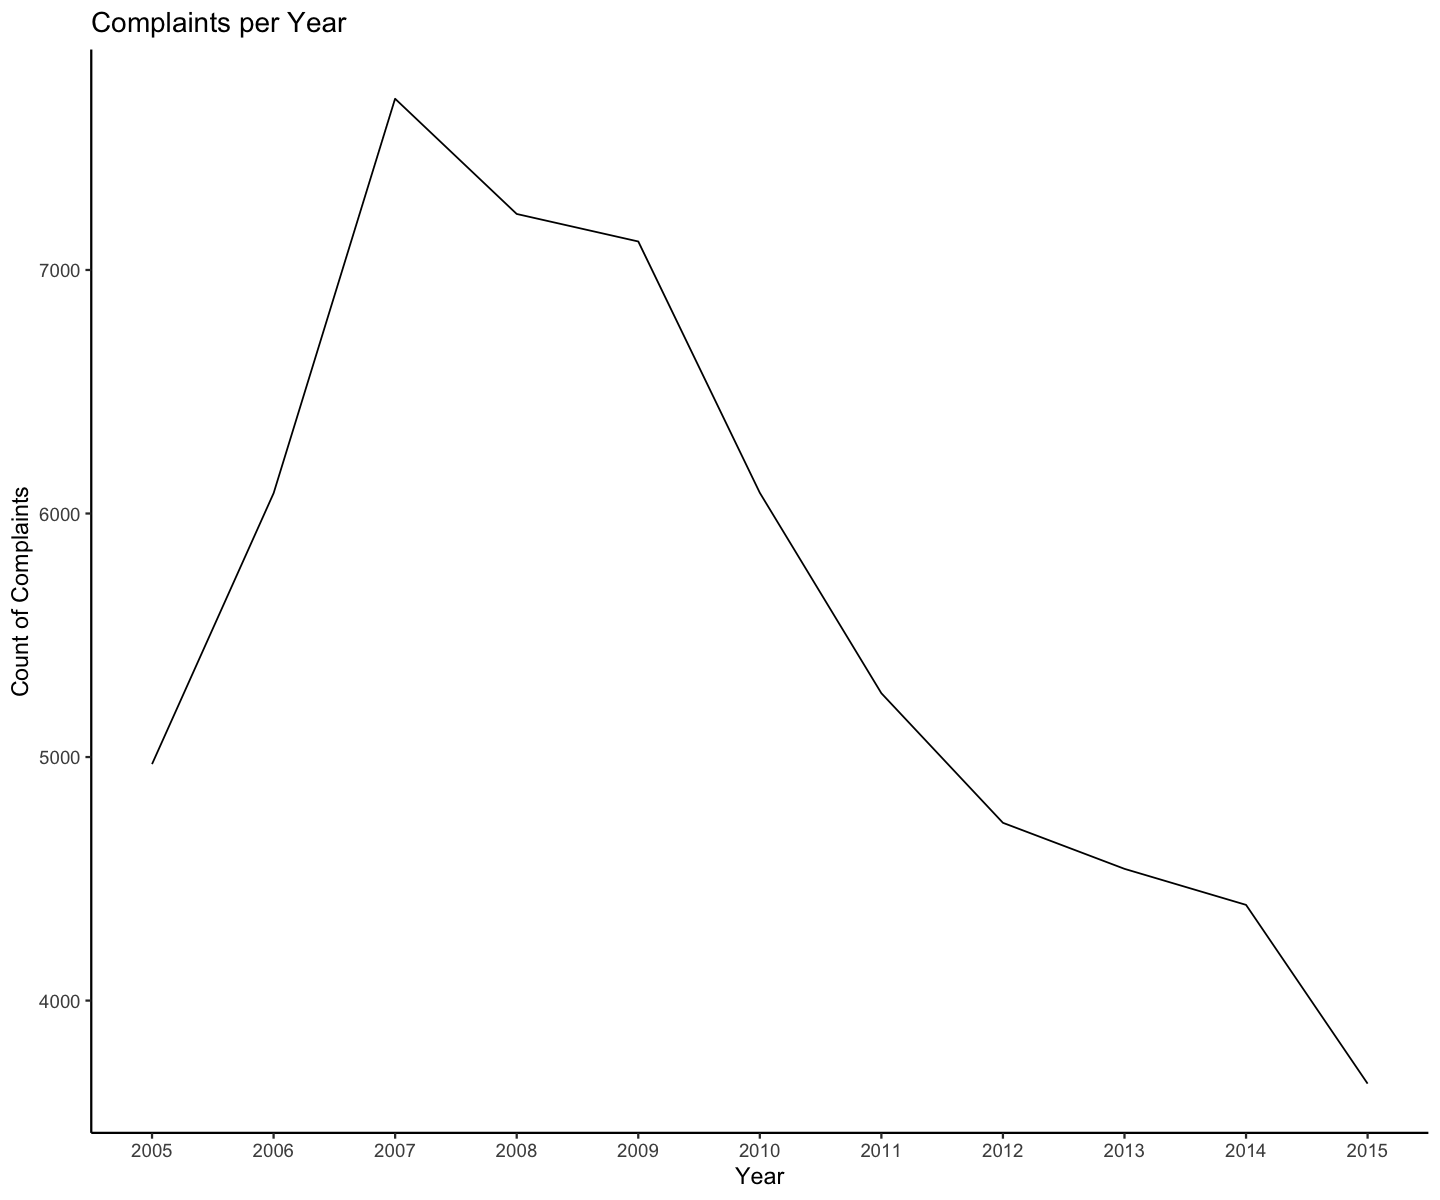

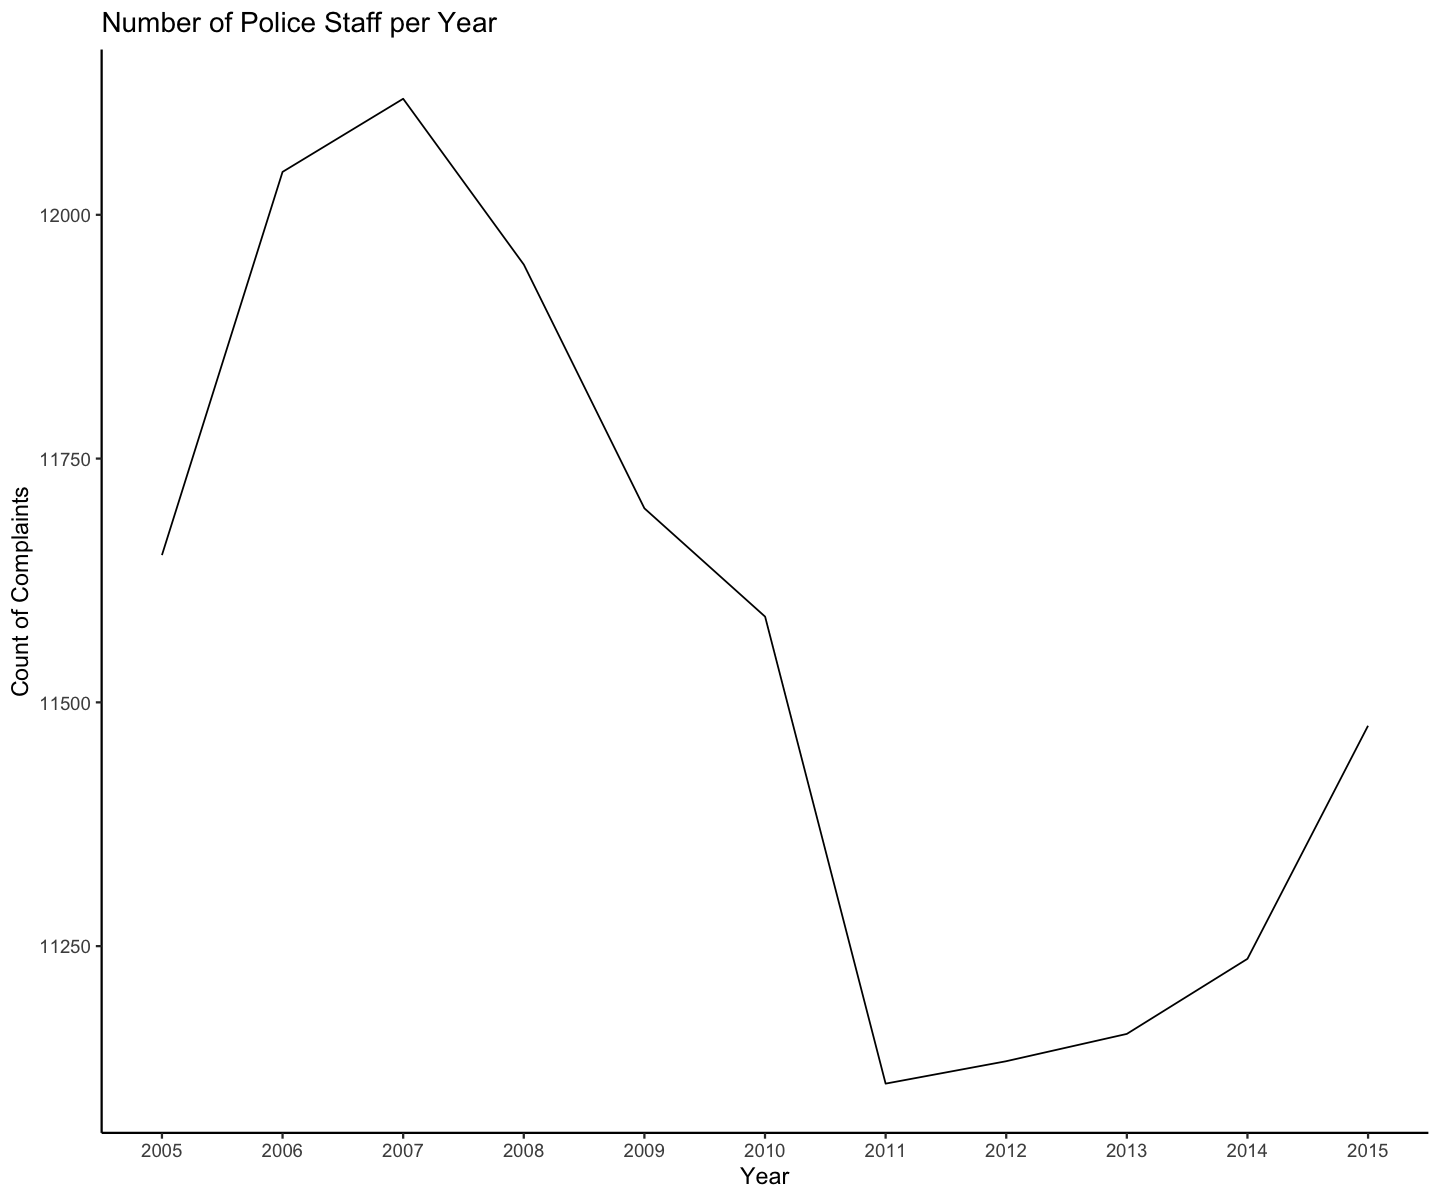

In [30]:
# Complaints by year
complaints_all_staff %>% 
    group_by(year) %>%
    summarize(n = sum(complaints_per_year)) %>%
    ggplot(aes(x = year, y = n)) + 
    geom_line() + 
    ggtitle("Complaints per Year") + 
    labs(x = "Year", y = "Count of Complaints") + 
    scale_x_continuous(breaks = 2005:2015)

# number of police staff/records per year (included in analysis)
complaints_all_staff %>% 
    count(year) %>%
    ggplot(aes(x = year, y = n)) + 
    geom_line() + 
    ggtitle("Number of Police Staff per Year") + 
    labs(x = "Year", y = "Count of Complaints") + 
    scale_x_continuous(breaks = 2005:2015)

`summarise()` ungrouping output (override with `.groups` argument)



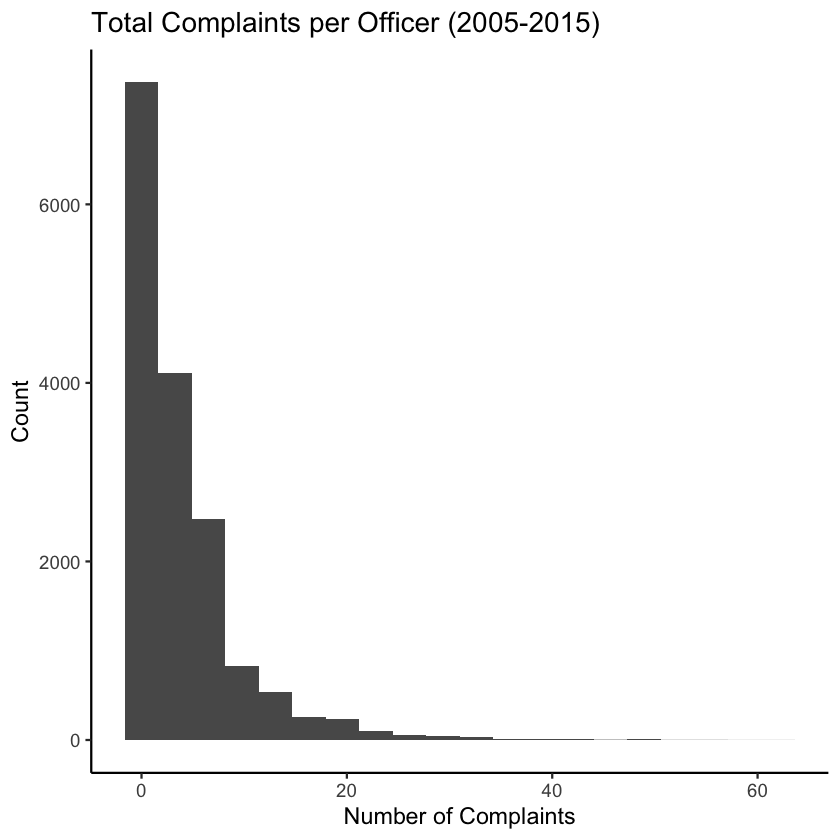

In [18]:
#Histogram of total complaints per officer - total complaints does not match because one complaint can be tied to multiple officers
complaints_all_staff %>% 
    group_by(link_UID) %>%
    summarize(n = sum(complaints_per_year)) %>%
    ggplot(aes(x = n)) +
    labs(x = "Number of Complaints", y = "Count") + 
    ggtitle("Total Complaints per Officer (2005-2015)") +
    geom_histogram(bins = 20)

`summarise()` regrouping output by 'link_UID' (override with `.groups` argument)



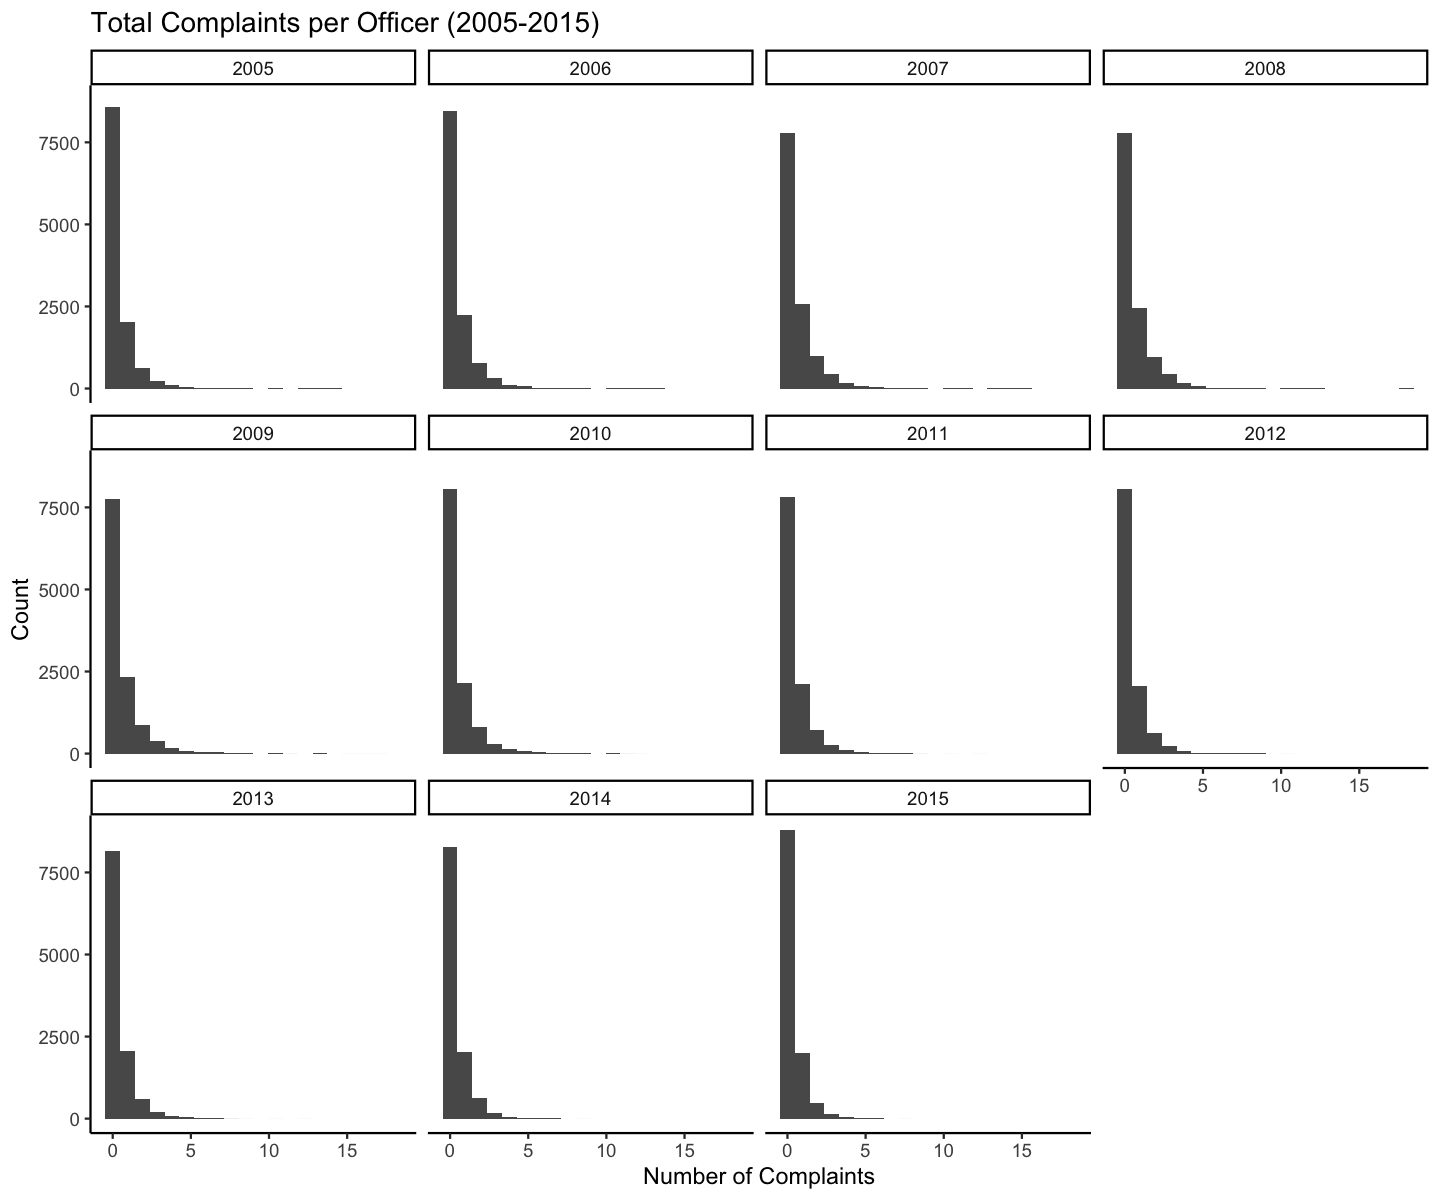

In [19]:
options(repr.plot.width=12, repr.plot.height=10)

#Faceted per year histogram
complaints_all_staff %>% 
    group_by(link_UID, year) %>%
    summarize(n = sum(complaints_per_year)) %>%
    ggplot(aes(x = n)) +
    labs(x = "Number of Complaints", y = "Count") + 
    ggtitle("Total Complaints per Officer (2005-2015)") +
    geom_histogram(bins = 20) +
    facet_wrap(~year, nrow=3)

`summarise()` ungrouping output (override with `.groups` argument)



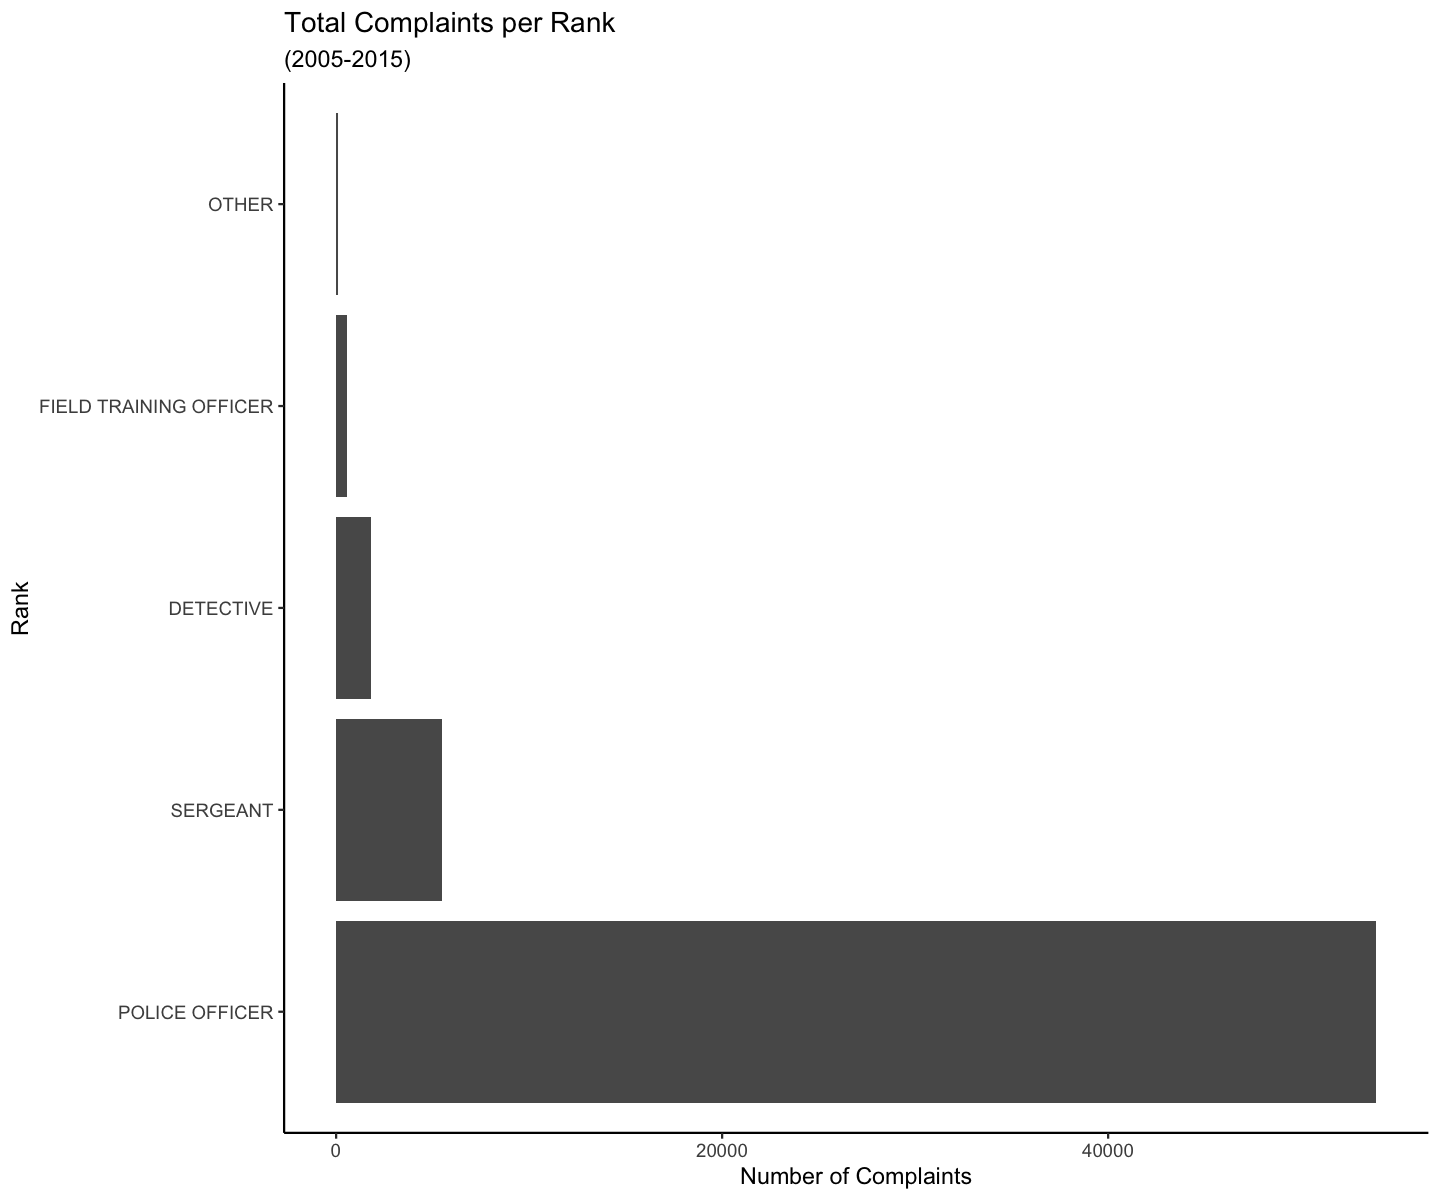

In [20]:
# complaints by officer rank
complaints_all_staff %>% 
    group_by(cleaned_rank) %>%
    summarize(n = sum(complaints_per_year)) %>%
    mutate(cleaned_rank = ifelse(n < 100, "OTHER", as.character(cleaned_rank))) %>%
    ggplot(aes(y=(reorder(cleaned_rank,-n)), x = n)) +
    labs(x = "Number of Complaints", y = "Rank", title = "Total Complaints per Rank", subtitle = "(2005-2015)") + 
    geom_col()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



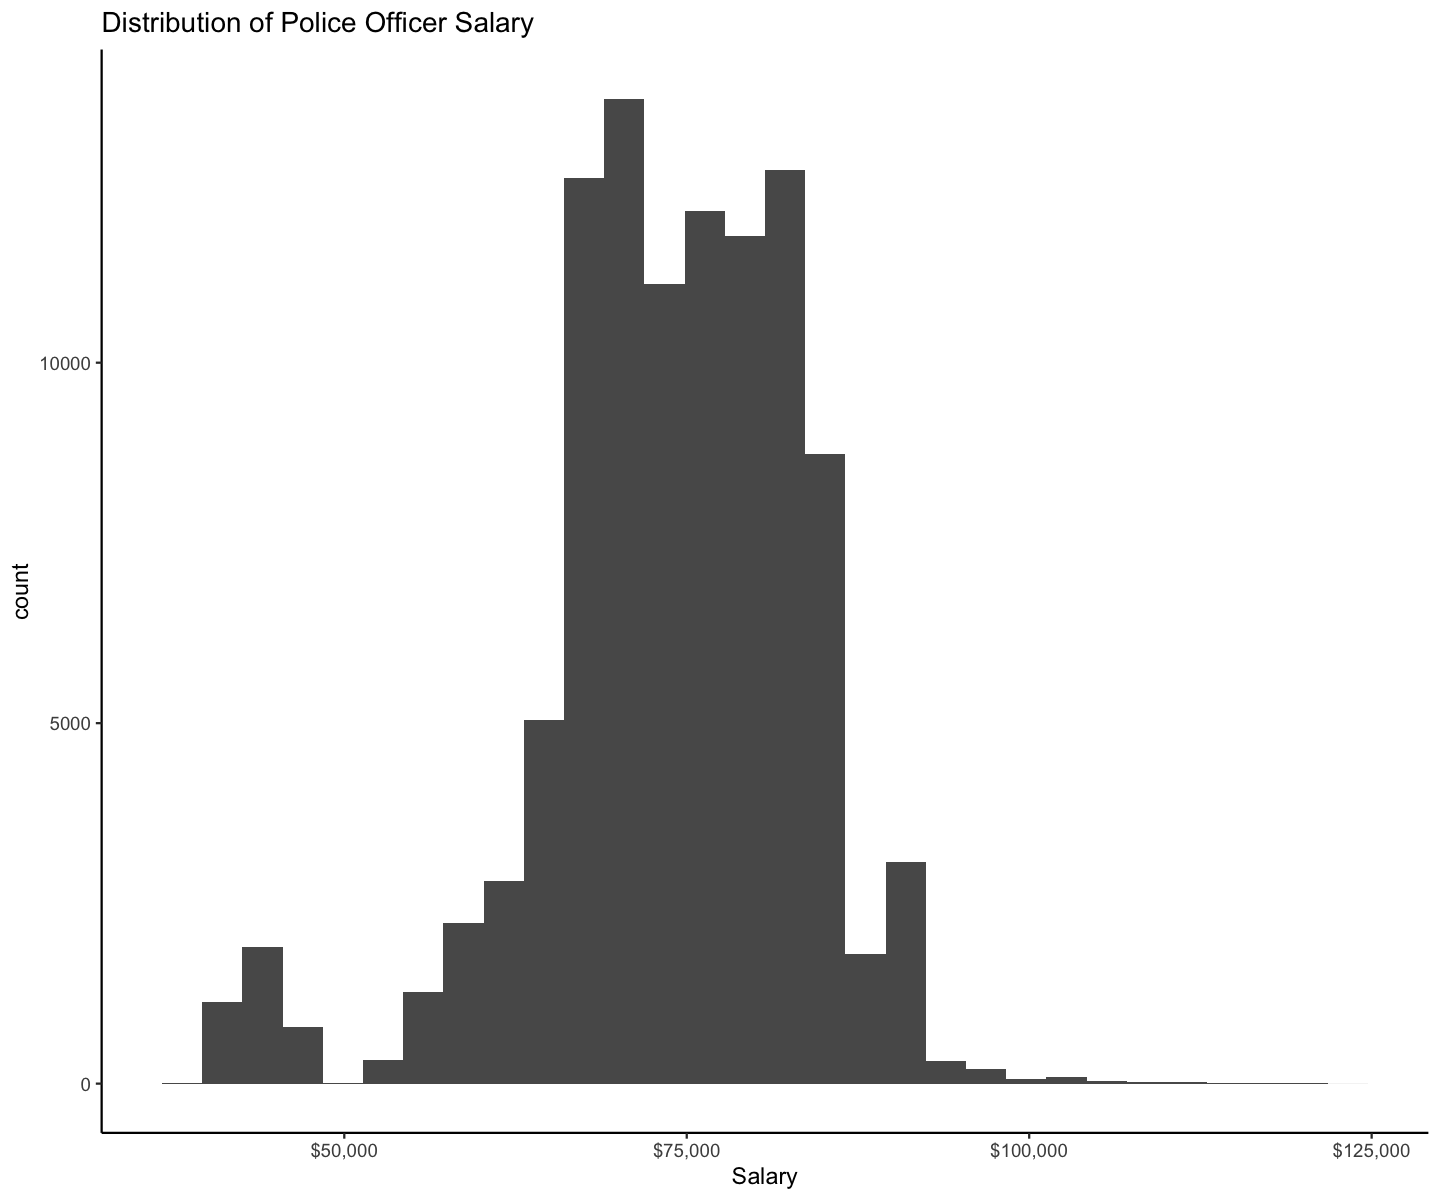

In [21]:
#Police Officer Salary Distribution
complaints_police %>% 
    ggplot(aes(x = salary)) + 
    geom_histogram() + 
    ggtitle("Distribution of Police Officer Salary") + 
    labs(x = "Salary") + 
    scale_x_continuous(labels = scales::label_dollar())

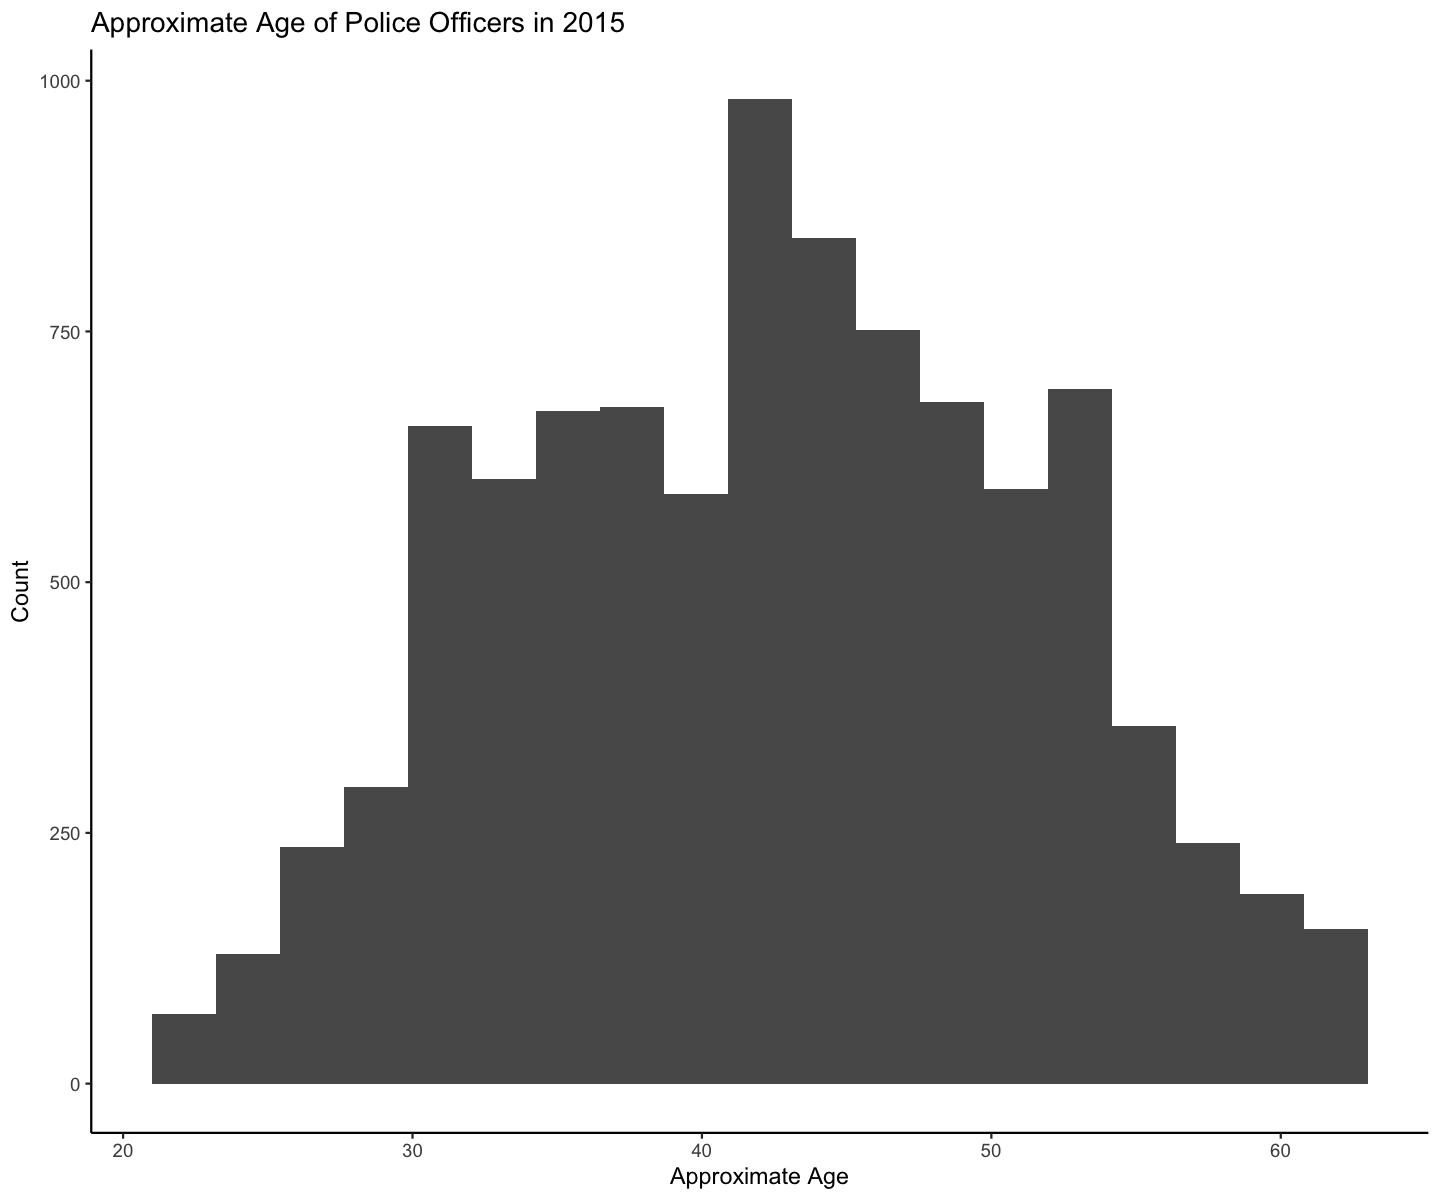

In [22]:
#Police Officer Age Dist (2015, chosen b/c a recent year that is pretty representative)
complaints_police %>% filter(year == 2015) %>% 
    ggplot(aes(x = approx_age)) + geom_histogram(bins = 20) +
    ggtitle("Approximate Age of Police Officers in 2015") +
    labs(x = "Approximate Age", y = "Count")

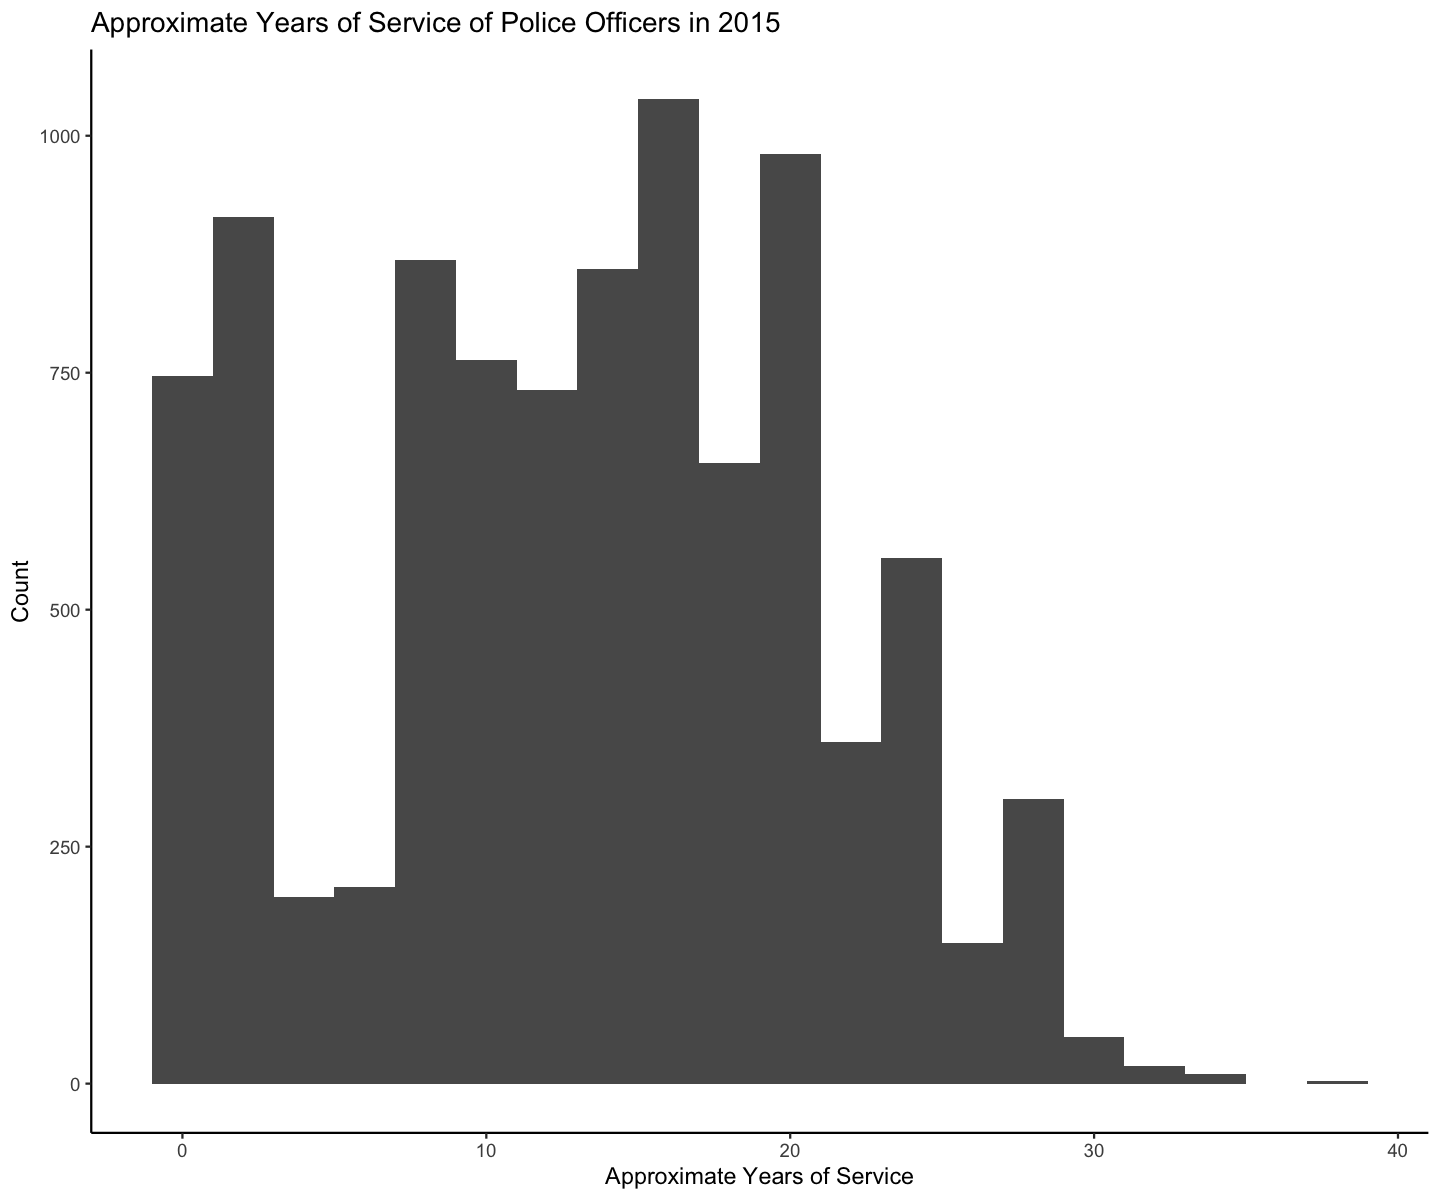

In [23]:
#Distribution of years of service in 2015
complaints_police %>% filter( year == 2015) %>% 
    ggplot(aes(x = approx_years_service)) + geom_histogram(bins = 20) +
    ggtitle("Approximate Years of Service of Police Officers in 2015") +
    labs(x = "Approximate Years of Service", y = "Count")

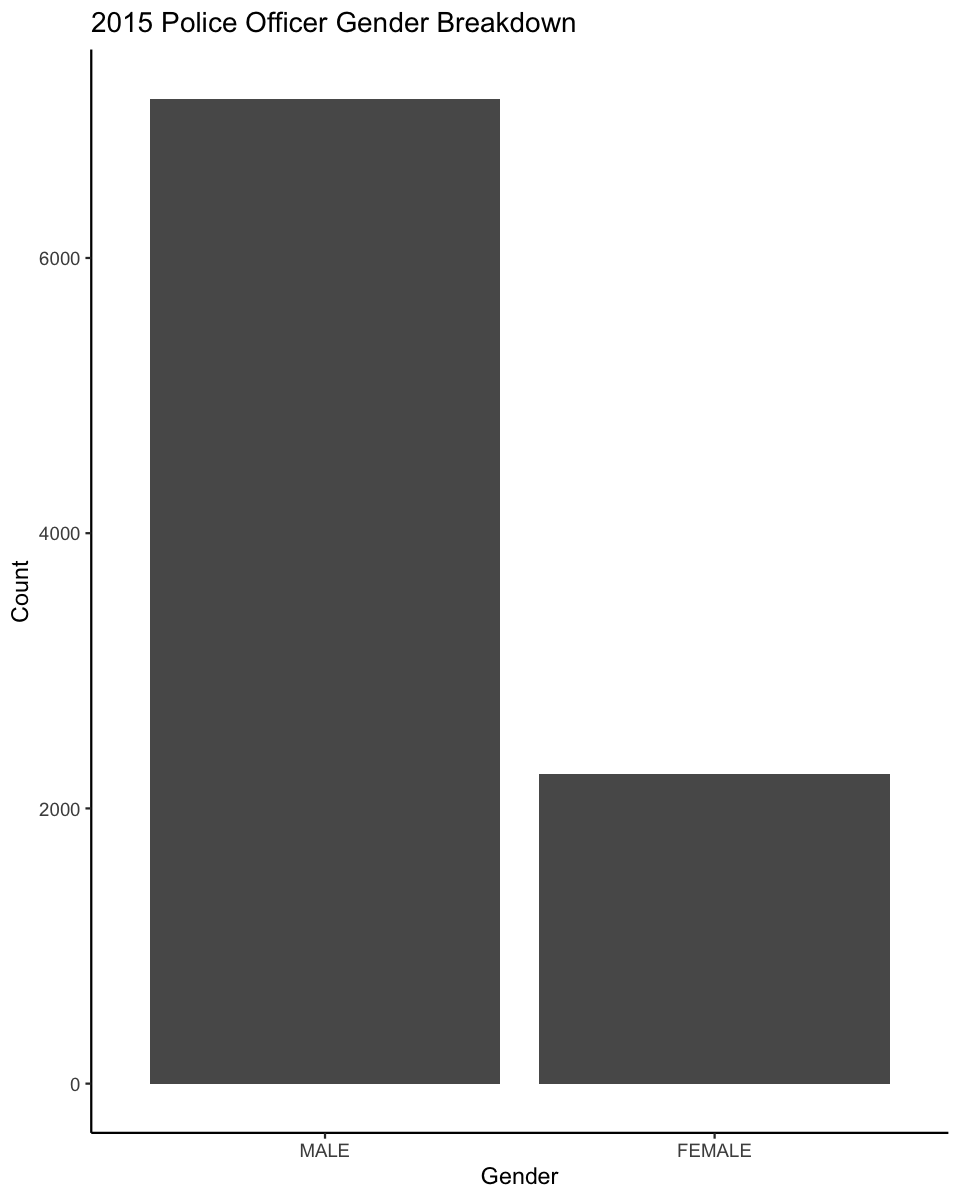

In [24]:
options(repr.plot.width=8, repr.plot.height=10)

# Gender Bar Chart 2015
complaints_police %>% filter(year == 2015) %>% group_by(year, gender) %>% 
    add_count(gender) %>% 
    ggplot(aes(x = reorder(gender, -n))) + 
    geom_bar() +
    ggtitle("2015 Police Officer Gender Breakdown") +
    labs(x = "Gender", y = "Count")


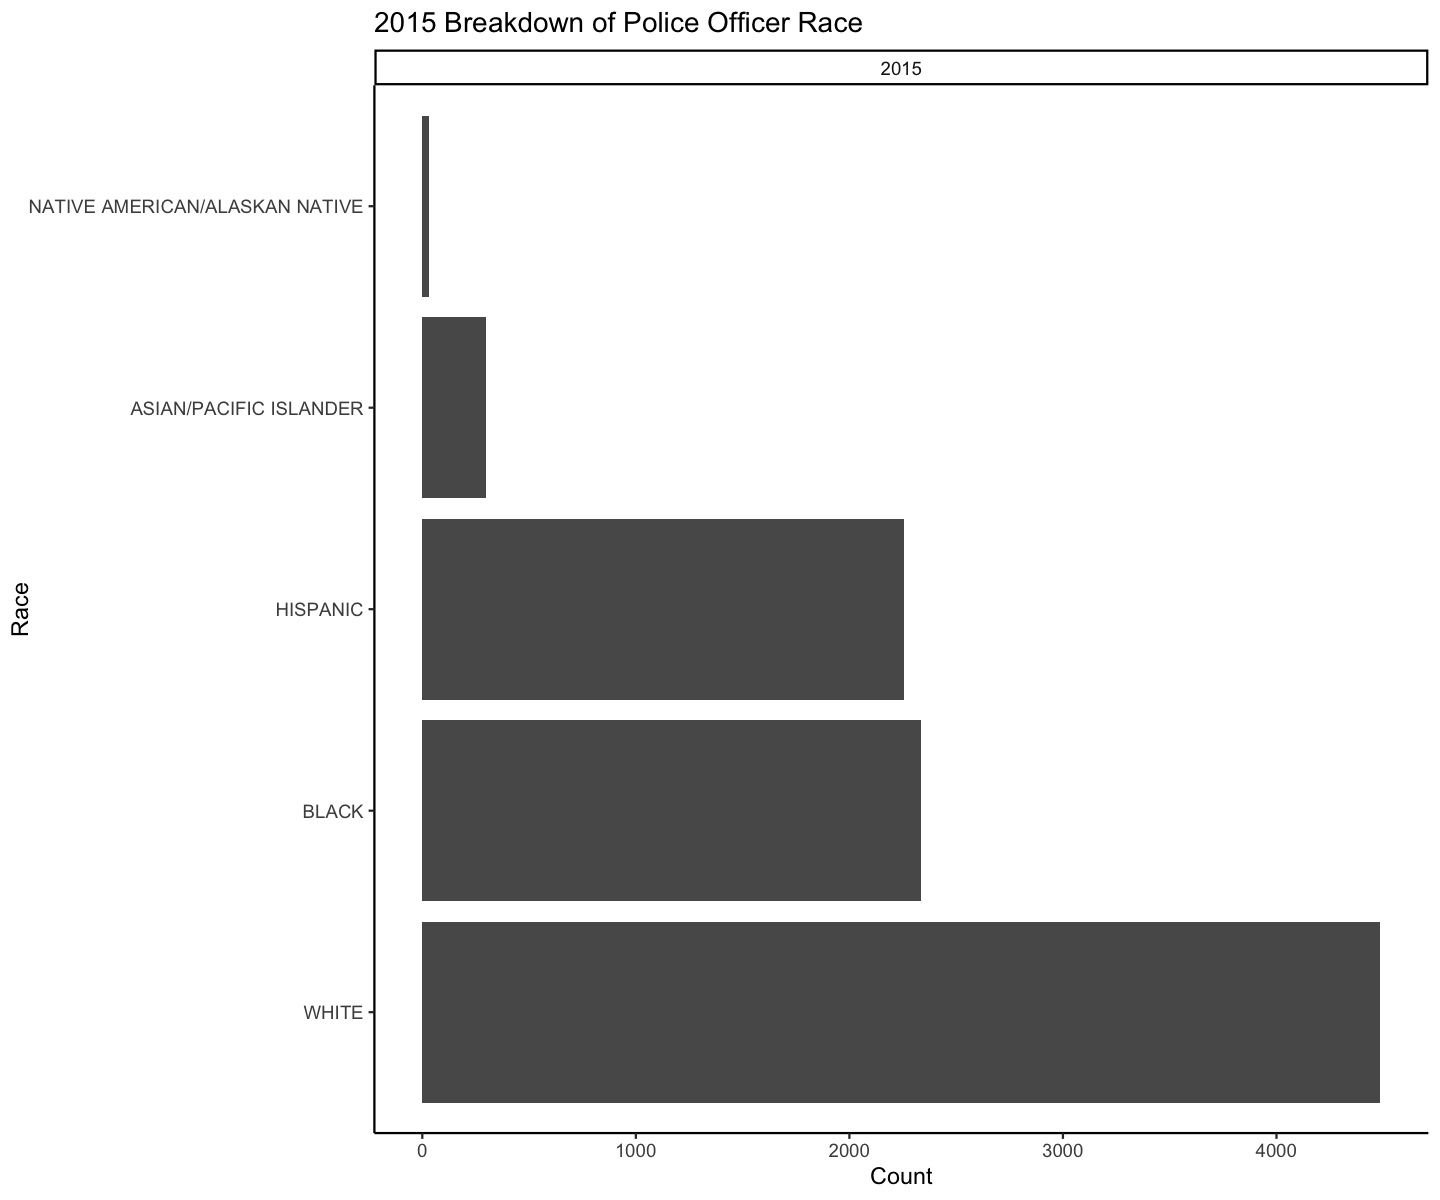

In [25]:
options(repr.plot.width=12, repr.plot.height=10)

# Race Bar Chart for 2015
complaints_police %>% filter(year == 2015) %>% group_by(year, race) %>% 
    add_count(race) %>% 
    ggplot(aes(y = reorder(race,-n))) + 
    geom_bar() + facet_wrap(~year) + 
    ggtitle("2015 Breakdown of Police Officer Race") +
    labs(x = "Count" , y = "Race")

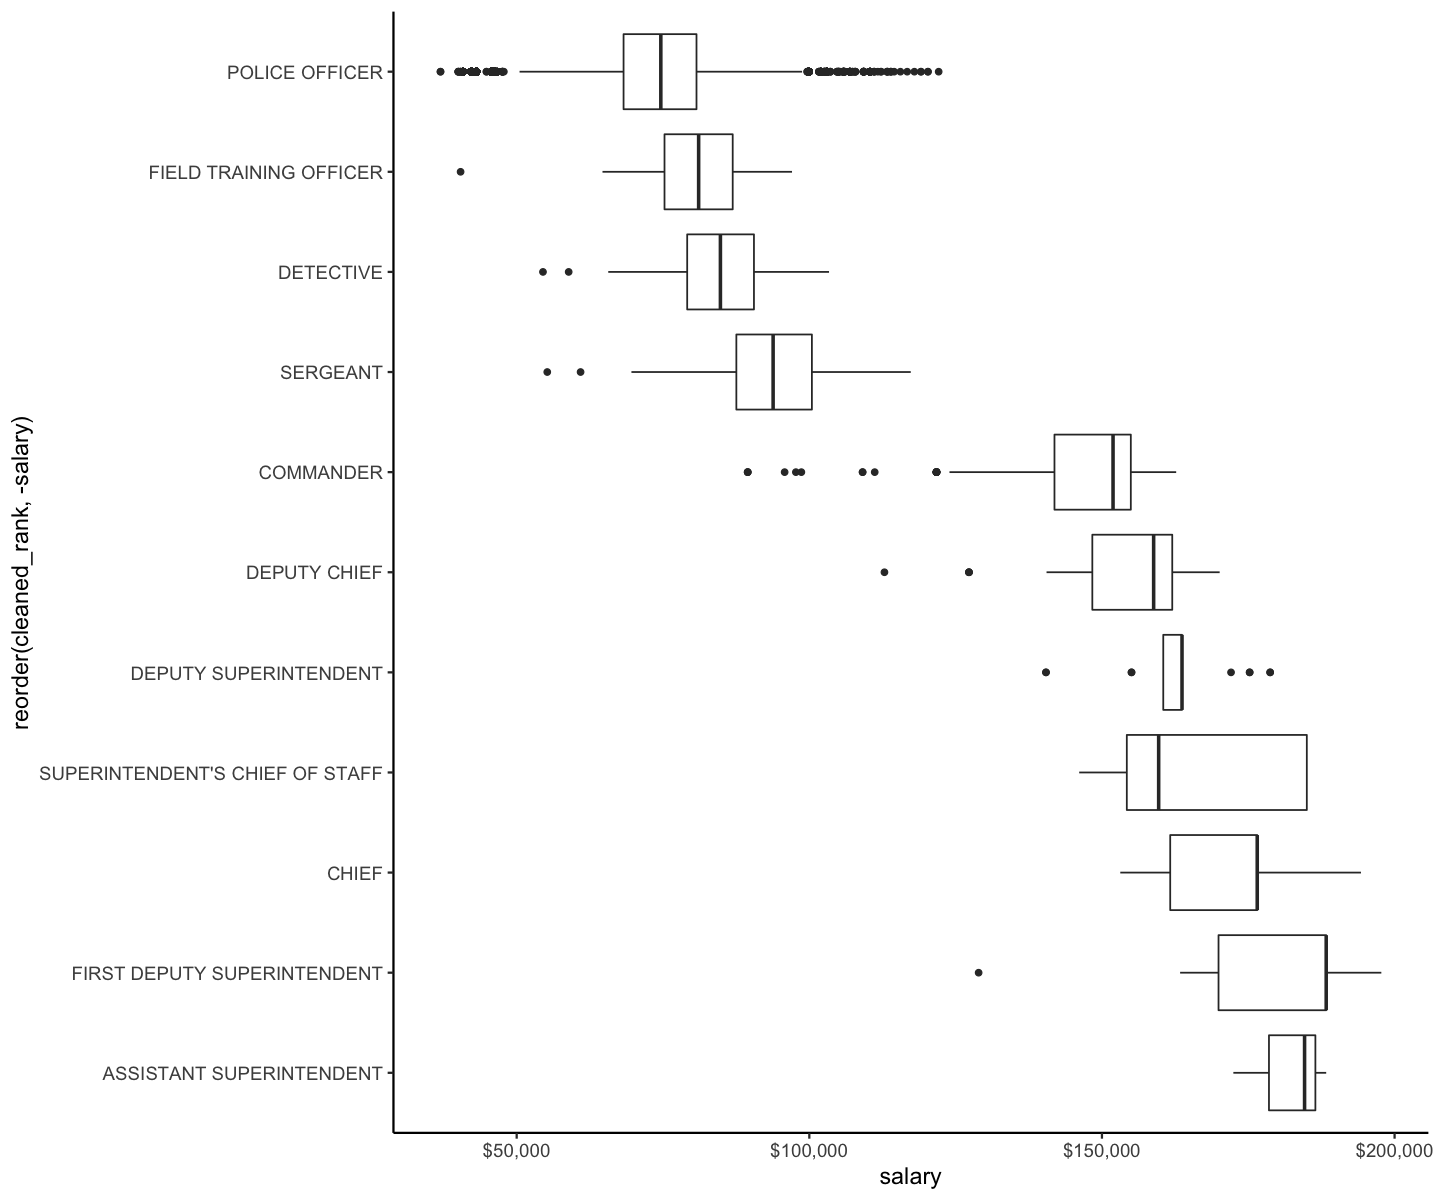

In [26]:
# Boxplot Salary
complaints_all_staff %>% 
    ggplot(aes(x = salary, y = reorder(cleaned_rank, -salary))) +
  geom_boxplot() + 
  scale_x_continuous(labels = scales::label_dollar())

`summarise()` ungrouping output (override with `.groups` argument)

`geom_smooth()` using formula 'y ~ x'



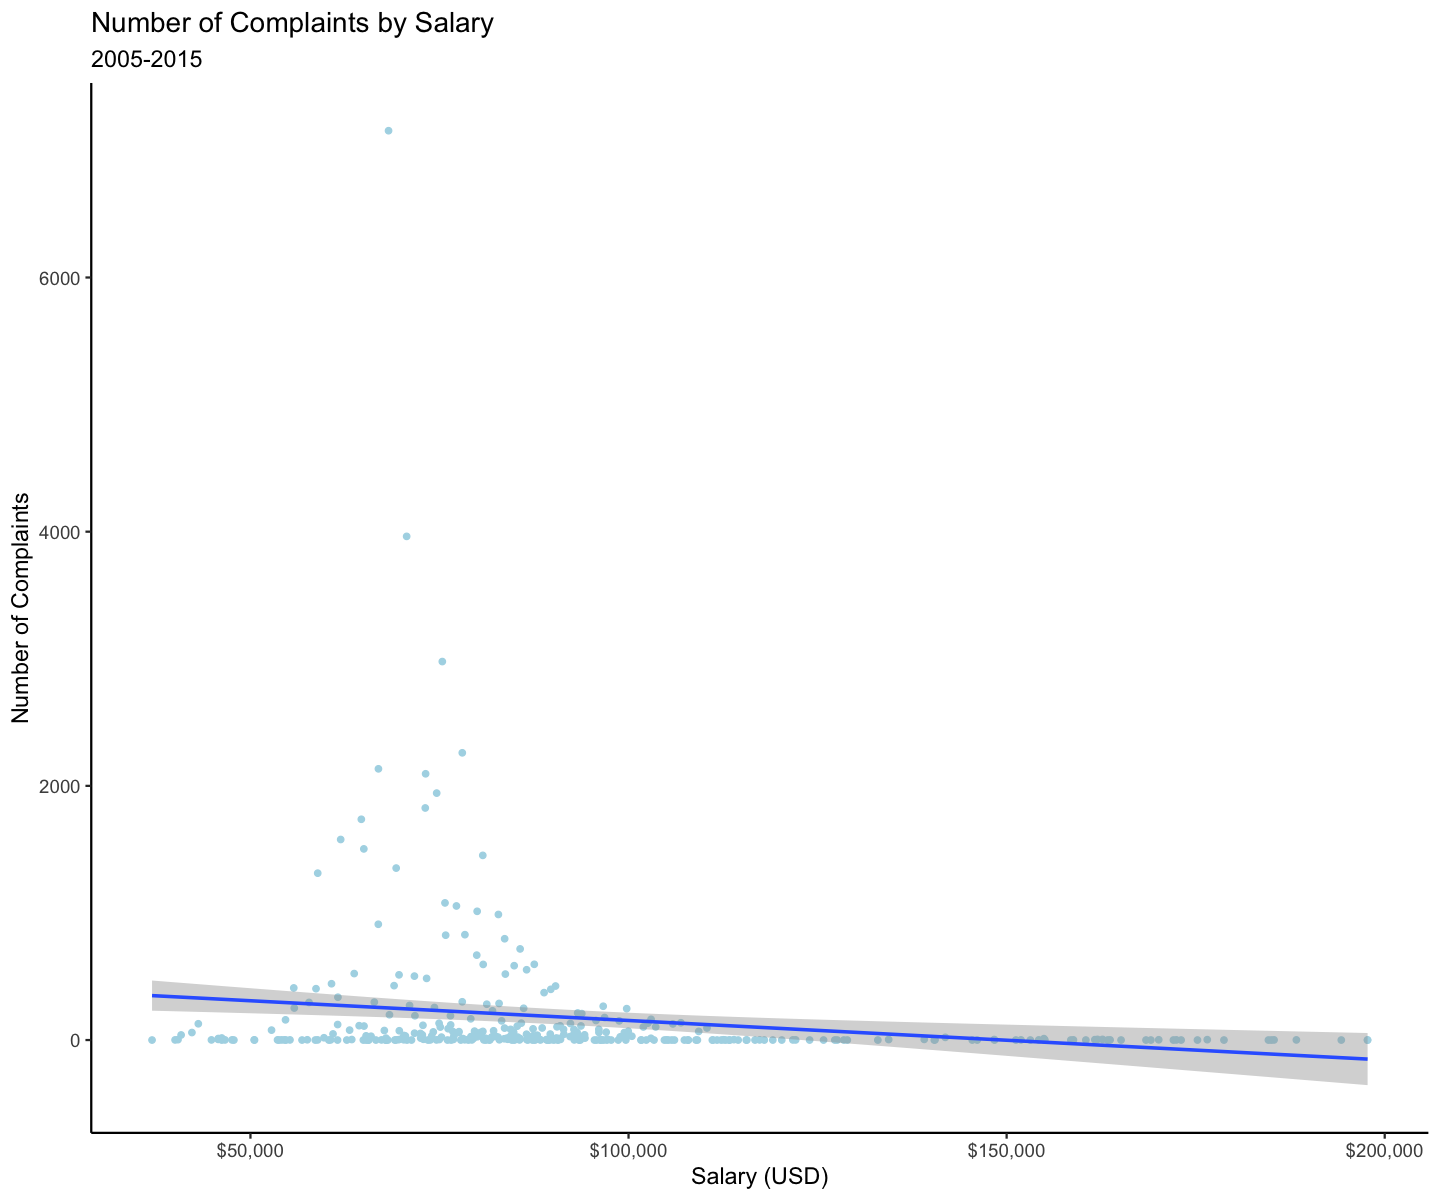

In [27]:
# complaints per salary
complaints_all_staff %>% 
    group_by(salary) %>% 
    summarize(num_complaints = sum(complaints_per_year)) %>%
    ggplot(aes(x = salary, y = num_complaints)) + 
        geom_point(color="lightblue") +
        scale_x_continuous(labels = scales::label_dollar()) +
        labs(title = "Number of Complaints by Salary", subtitle = "2005-2015", x = "Salary (USD)", y = "Number of Complaints") + 
        geom_smooth(method=lm)

In [28]:
# # calculate a complaint rate
# compaint_rates <- df_merged %>%
#     group_by(salary, year) %>%
#     summarize(num_complaints = sum(!is.na(cr_id)), num_employees = sum(!is.na(UID))) %>%
#     mutate(complaint_rate = num_complaints / num_employees)

# #compaint_rates
# ggplot(compaint_rates, aes(x = salary, y = complaint_rate)) + 
#         geom_point(color = "lightblue") +
#         scale_x_continuous(labels = scales::label_dollar()) + 
#         labs(title="Complaint Rate by Salary", subtitle = "2005-2015", x = "Salary USD", y = "Complaint Rate (# complaints/ # employees)") + 
#         geom_smooth(method=lm)

In [29]:
#Correlation Matrix ggpairs

png("test.png")
corr_matrix <- complaints_police %>% 
    select(salary, approx_age, approx_years_service, complaints_per_year) %>% 
    GGally::ggpairs(progress=FALSE)

print(corr_matrix)
dev.off()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



pdf 
  2